In [1]:
from __future__ import annotations

import math
import os
import pickle
import shutil
from itertools import combinations
from typing import TypeAlias

import cv2
import numpy as np
import numpy.typing as npt
from matplotlib import pyplot as plt
from tqdm import tqdm

from utils import preview_contents

In [2]:
Image: TypeAlias = npt.NDArray[np.integer]

Pixel: TypeAlias = npt.NDArray[np.integer]
PixelArray: TypeAlias = npt.NDArray[np.integer]

Point: TypeAlias = npt.NDArray[np.floating]
PointArray: TypeAlias = npt.NDArray[np.floating]

Piece: TypeAlias = dict[str, str | Image | PixelArray | PointArray]

# Implementation

## Load data

In [3]:
def get_piece_name(path: str) -> str:
    return os.path.splitext(os.path.split(path)[1])[0]


def load_img(path: str) -> Piece:
    assert os.path.exists(path)

    img = cv2.imread(path)
    # Make sure images are oriented horizontally (for preview)
    if img.shape[0] > img.shape[1]:
        img = np.rot90(img)

    return np.ascontiguousarray(img)

In [4]:
imgs_directory = os.path.join("data", "imgs")

SAMPLE = []
for file_name in tqdm(os.listdir(imgs_directory)):
    piece_name = get_piece_name(file_name)

    if piece_name in ["0021", "0024", "0025", "0026"]:
        SAMPLE.append(
            {
                "name": piece_name,
                "img": load_img(os.path.join(imgs_directory, file_name)),
            }
        )

100%|██████████| 40/40 [00:00<00:00, 52.87it/s]


## Preview utils

Piece dict:
[{'img': <class 'numpy.ndarray'>, 'name': <class 'str'>}]

Raw images preview:


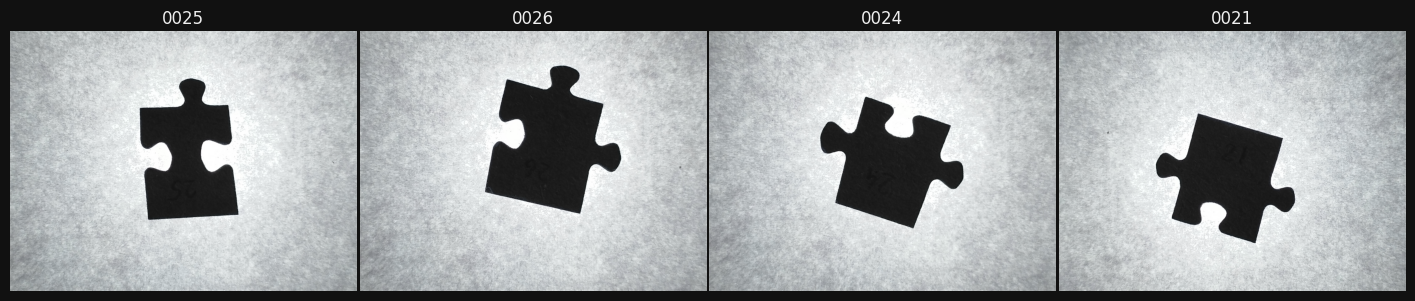

In [5]:
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)

plt.rcParams.update(
    {
        "figure.facecolor": "#111",
        "axes.facecolor": "#111",
        "text.color": "#eee",
        "axes.labelcolor": "#eee",
        "xtick.color": "#eee",
        "ytick.color": "#eee",
        "image.cmap": "cividis",
    }
)


def show_imgs(pieces: list[Piece], imgs_name: str) -> None:
    titles = []
    imgs = []
    for piece in pieces:
        titles.append(piece["name"])
        imgs.append(piece[imgs_name])

    n_cols = 4
    n_rows = math.ceil(len(imgs) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols)

    if isinstance(axes, plt.Axes):
        axes = [axes]
    else:
        axes = list(axes.flat)

    fig.set_figwidth(18)
    fig.set_figheight(8)
    fig.subplots_adjust(wspace=0.01, hspace=0.1)
    fig.set_dpi(100)

    for ax in axes:
        ax.set_axis_off()

    for ax, img, title in zip(axes, imgs, titles):
        ax.set_title(title)
        ax.imshow(img)

    plt.show()


print("Piece dict:")
preview_contents(SAMPLE)

print("\nRaw images preview:")
show_imgs(SAMPLE, "img")

## Binarization

This is a 3 step process:
1. Convert the image to grayscale, simplifying the color information for subsequent processing.
2. Apply a blur to the image to reduce high-frequency noise, ensuring not to overdo it, so that crucial edge details are preserved.
3. Convert pixel values to binary based on a visually estimated threshold.


In [6]:
def to_grayscale(img: Image) -> Image:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def to_blurred(img: Image) -> Image:
    return cv2.medianBlur(img, ksize=11)


def to_binary(img: Image) -> Image:
    return cv2.threshold(src=img, thresh=115, maxval=255, type=cv2.THRESH_BINARY)[1]

In [7]:
for piece in tqdm(SAMPLE):
    piece["grayscale"] = to_grayscale(piece["img"])
    piece["blurred"] = to_blurred(piece["grayscale"])
    piece["binary"] = to_binary(piece["blurred"])

print("Piece dict:")
preview_contents(SAMPLE)

100%|██████████| 4/4 [00:01<00:00,  3.56it/s]

Piece dict:
[{'binary': <class 'numpy.ndarray'>,
  'blurred': <class 'numpy.ndarray'>,
  'grayscale': <class 'numpy.ndarray'>,
  'img': <class 'numpy.ndarray'>,
  'name': <class 'str'>}]


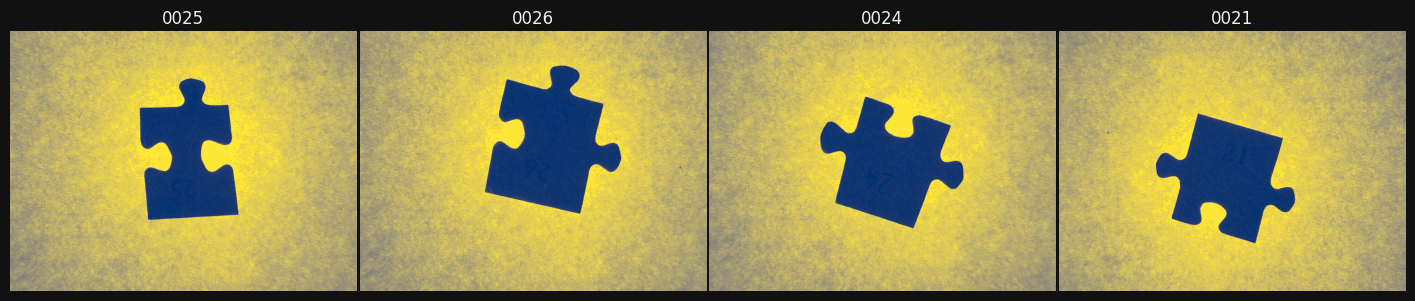

In [8]:
show_imgs(SAMPLE, "grayscale")

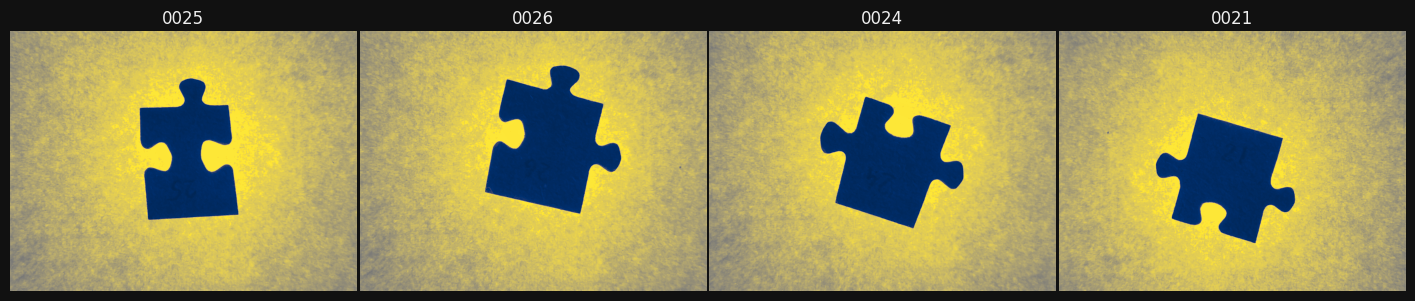

In [9]:
show_imgs(SAMPLE, "blurred")

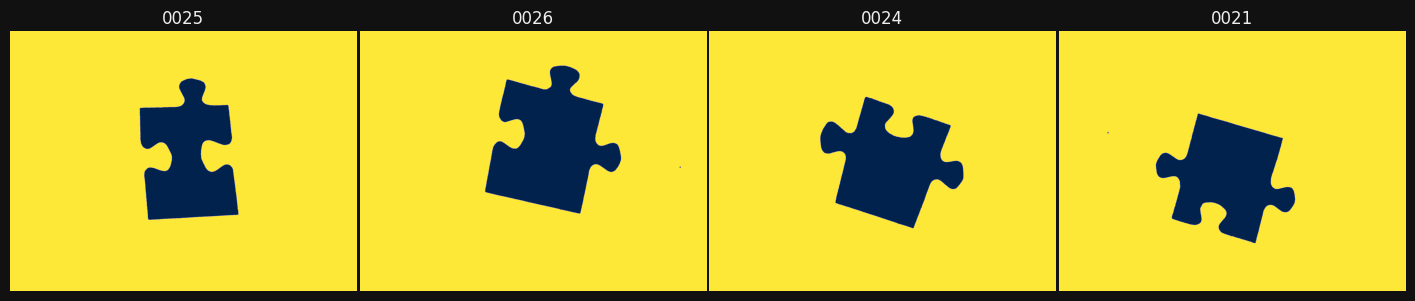

In [10]:
show_imgs(SAMPLE, "binary")

## Edge detection

Detect edges on a binary image and eliminate noise by assuming that the puzzle piece's edge corresponds to the second largest connected component, with the largest being the background.


In [11]:
def to_edges(img: Image) -> Image:
    canny = cv2.Canny(img.astype(np.uint8), 255, 255)

    n_labels, labels, stats, _ = cv2.connectedComponentsWithStats(canny, connectivity=8)

    second_largest_component = sorted(
        zip(range(n_labels), stats), key=lambda x: x[1][cv2.CC_STAT_AREA], reverse=True
    )[1][0]

    return (labels == second_largest_component).astype(np.uint8) * 255

100%|██████████| 4/4 [00:00<00:00, 26.70it/s]


Piece dict:
[{'binary': <class 'numpy.ndarray'>,
  'blurred': <class 'numpy.ndarray'>,
  'edge': <class 'numpy.ndarray'>,
  'grayscale': <class 'numpy.ndarray'>,
  'img': <class 'numpy.ndarray'>,
  'name': <class 'str'>}]


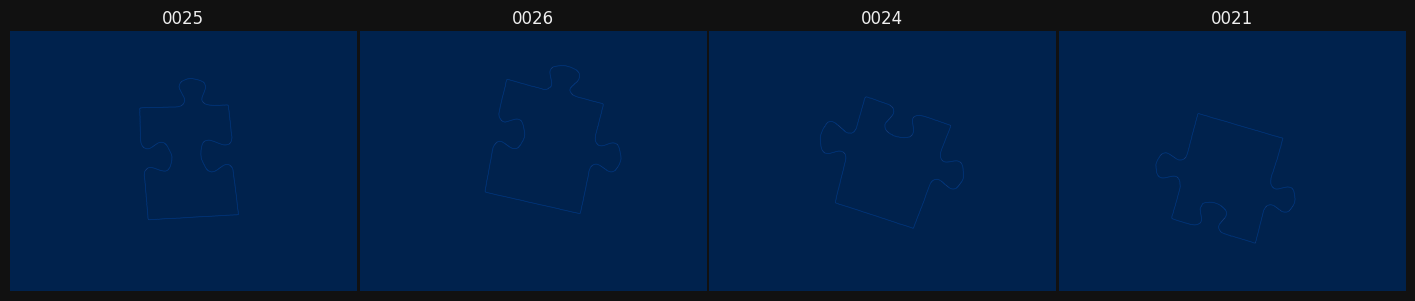

In [12]:
for piece in tqdm(SAMPLE):
    piece["edge"] = to_edges(piece["binary"])

print("Piece dict:")
preview_contents(SAMPLE)

show_imgs(SAMPLE, "edge")

## Edge pixels extraction

Extract an array of pixels from an image containing the edge of a puzzle piece.


In [13]:
def get_edge_pixels(img: Image) -> PixelArray:
    pixels = np.nonzero(img)
    pixels = np.column_stack(pixels)  # stack array of columns to array of rows
    pixels = np.roll(pixels, 1, axis=1)  # swap [y, x] to [x, y]
    return pixels

100%|██████████| 4/4 [00:00<00:00, 19.29it/s]


Piece dict:
[{'binary': <class 'numpy.ndarray'>,
  'blurred': <class 'numpy.ndarray'>,
  'edge': <class 'numpy.ndarray'>,
  'edge_pixels': <class 'numpy.ndarray'>,
  'grayscale': <class 'numpy.ndarray'>,
  'img': <class 'numpy.ndarray'>,
  'name': <class 'str'>,
  'preview': <class 'numpy.ndarray'>}]


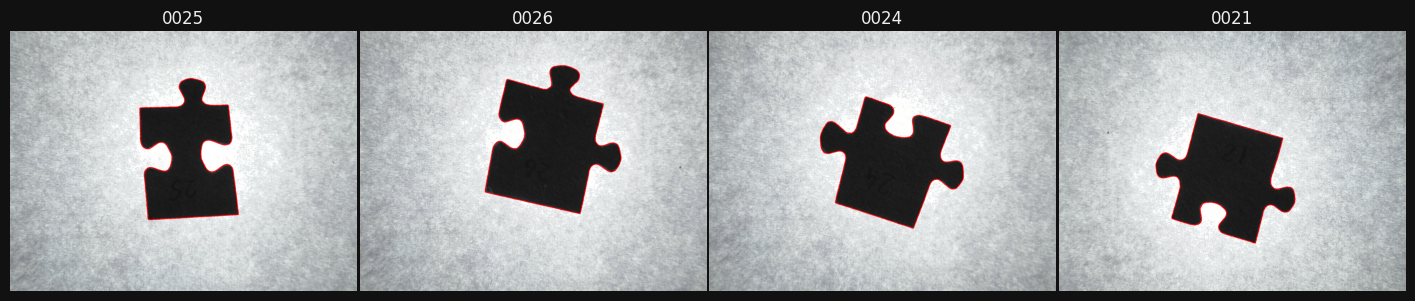

In [14]:
for piece in tqdm(SAMPLE):
    piece["edge_pixels"] = get_edge_pixels(piece["edge"])

    piece["preview"] = piece["img"].copy()
    for pixel in piece["edge_pixels"]:
        pixel = np.int32(pixel)
        piece["preview"] = cv2.circle(
            piece["preview"], pixel, radius=5, color=RED, thickness=-1
        )

print("Piece dict:")
preview_contents(SAMPLE)

show_imgs(SAMPLE, "preview")

## Corner estimation

Identify regions in the image where corners may be present. Get centroids of those regions.


In [15]:
def to_harris(img: Image) -> Image:
    img_harris = cv2.cornerHarris(img, blockSize=31, ksize=17, k=0.1)
    thresh = 0.05 * img_harris.max()
    return img_harris > thresh


def get_corners(img: Image) -> PointArray:
    *_, centroids = cv2.connectedComponentsWithStats(img.astype(np.uint8))
    return centroids[1:]

100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Piece dict:
[{'binary': <class 'numpy.ndarray'>,
  'blurred': <class 'numpy.ndarray'>,
  'corners_potential': <class 'numpy.ndarray'>,
  'edge': <class 'numpy.ndarray'>,
  'edge_pixels': <class 'numpy.ndarray'>,
  'grayscale': <class 'numpy.ndarray'>,
  'harris': <class 'numpy.ndarray'>,
  'img': <class 'numpy.ndarray'>,
  'name': <class 'str'>,
  'preview': <class 'numpy.ndarray'>}]


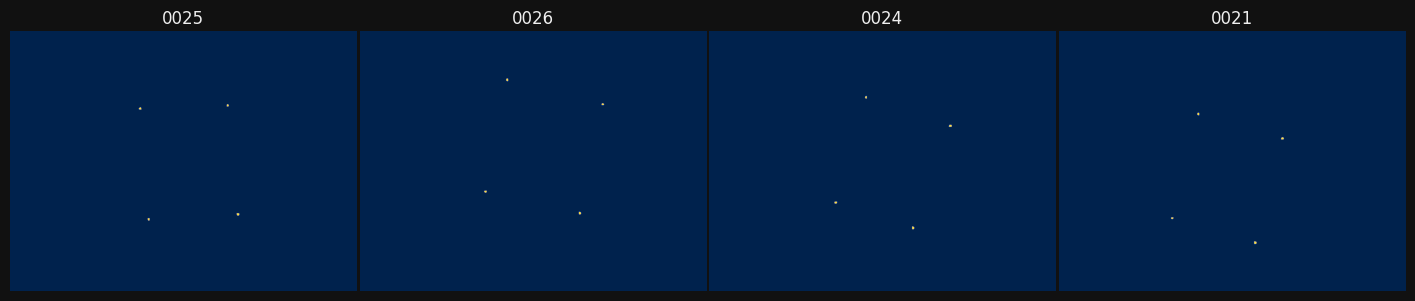

In [16]:
for piece in tqdm(SAMPLE):
    piece["harris"] = to_harris(piece["edge"])
    piece["corners_potential"] = get_corners(piece["harris"])

print("Piece dict:")
preview_contents(SAMPLE)

show_imgs(SAMPLE, "harris")

100%|██████████| 4/4 [00:00<00:00, 42.36it/s]


Piece dict:
[{'binary': <class 'numpy.ndarray'>,
  'blurred': <class 'numpy.ndarray'>,
  'corners_potential': <class 'numpy.ndarray'>,
  'edge': <class 'numpy.ndarray'>,
  'edge_pixels': <class 'numpy.ndarray'>,
  'grayscale': <class 'numpy.ndarray'>,
  'harris': <class 'numpy.ndarray'>,
  'img': <class 'numpy.ndarray'>,
  'name': <class 'str'>,
  'preview': <class 'numpy.ndarray'>}]


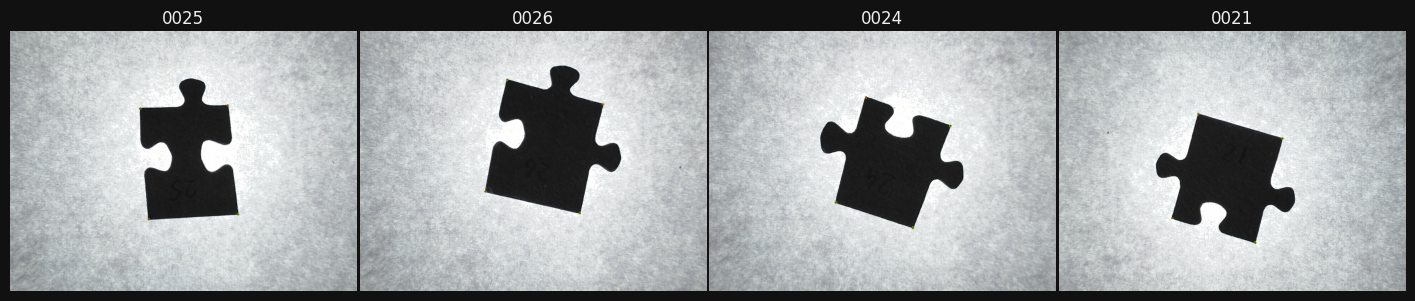

In [17]:
for piece in tqdm(SAMPLE):
    piece["preview"] = piece["img"].copy()

    piece["preview"][piece["harris"]] = GREEN

    for point in piece["corners_potential"]:
        point = np.int32(point)
        piece["preview"] = cv2.circle(
            piece["preview"], point, radius=10, color=RED, thickness=-1
        )

print("Piece dict:")
preview_contents(SAMPLE)

show_imgs(SAMPLE, "preview")

## Corner selection

Among the potential corner centroids estimated in the previous step, choose the four most likely ones to represent the corners of the puzzle piece.

**Step 1:**

Iterate over all combinations of 4 points. A combination is discarded if the angle between any three consecutive points deviates from 90 degrees by more than the specified tolerance.

**Step 2:**

From the remaining combinations, choose the one with the largest area between points.

**Note:**

Note that for every combination, points are sorted clockwise. This is required for both selecting consecutive points and calculating area.


In [18]:
def _sort_points(points: PointArray) -> PointArray:
    """Sort list of points clockwise."""

    centroid = points.mean(axis=0)
    cx, cy = centroid

    x, y = points.T
    angles = np.arctan2(x - cx, y - cy)

    return points[np.argsort(angles)]


# TODO: Replace with numpy: https://rosettacode.org/wiki/Shoelace_formula_for_polygonal_area#Python
def _shoelace_area(points: PointArray) -> float:
    """Calculate area of a polygon described by a sorted list of points."""

    n = len(points)
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += points[i][0] * points[j][1]
        area -= points[j][0] * points[i][1]
    area = abs(area) / 2.0
    return area


def _angle_between_points(a: Point, b: Point, c: Point) -> float:
    """
    Calculate angle between points a, b, c, going from point a to c through b.

    This only returns 0-90 degrees (arccos).
    """

    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)

    return np.degrees(angle)


def select_corners(corners: PointArray) -> PointArray:
    best_combination = None
    best_area = 0.0

    for combination in combinations(corners, 4):
        combination = _sort_points(np.array(combination))

        # Step 1: eliminate combination based on angles
        for i in range(4):
            left, center, right = combination[i - 2], combination[i - 1], combination[i]

            angle = _angle_between_points(left, center, right)

            if abs(90 - angle) > 15.0:
                break

        # Step 2: choose combination with largest area
        else:
            area = _shoelace_area(combination)
            if best_area < area:
                best_combination = combination
                best_area = area

    # Sanity check - if the correct combination is there, we should be able to select it
    assert best_combination is not None

    return best_combination

100%|██████████| 4/4 [00:00<00:00, 155.31it/s]


Piece dict:
[{'binary': <class 'numpy.ndarray'>,
  'blurred': <class 'numpy.ndarray'>,
  'corners_potential': <class 'numpy.ndarray'>,
  'corners_selected': <class 'numpy.ndarray'>,
  'edge': <class 'numpy.ndarray'>,
  'edge_pixels': <class 'numpy.ndarray'>,
  'grayscale': <class 'numpy.ndarray'>,
  'harris': <class 'numpy.ndarray'>,
  'img': <class 'numpy.ndarray'>,
  'name': <class 'str'>,
  'preview': <class 'numpy.ndarray'>}]


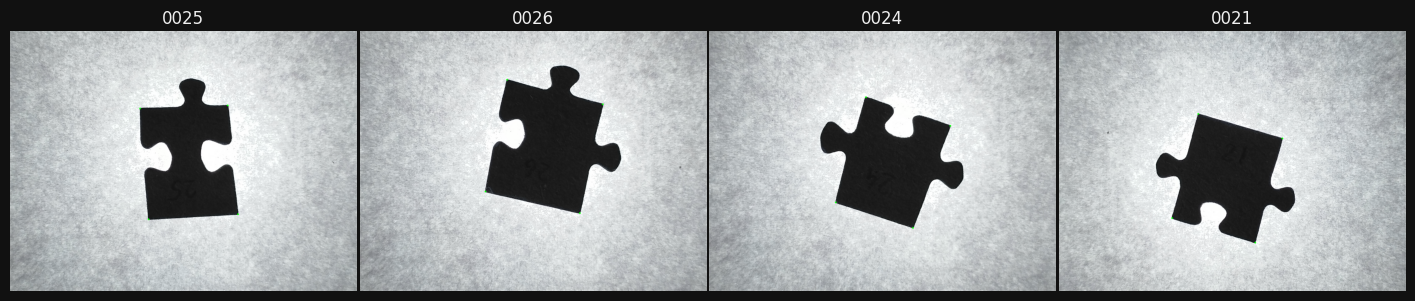

In [19]:
for piece in tqdm(SAMPLE):
    piece["corners_selected"] = select_corners(piece["corners_potential"])

    piece["preview"] = piece["img"].copy()

    for point in piece["corners_potential"]:
        piece["preview"] = cv2.circle(
            piece["preview"],
            center=np.int32(point),
            radius=10,
            color=GREEN if point in piece["corners_selected"] else RED,
            thickness=-1,
        )

print("Piece dict:")
preview_contents(SAMPLE)

show_imgs(SAMPLE, "preview")

## Corner refinement

Refine corners through an iterative process. Note that base image should be binary image, not the one with edges.


In [20]:
def refine_corners(img: Image, corners: PointArray) -> PointArray:
    return cv2.cornerSubPix(
        image=img,
        corners=np.float32(corners),
        winSize=(35, 35),
        zeroZone=(-1, -1),
        criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001),
    )

100%|██████████| 4/4 [00:00<00:00, 75.50it/s]


Piece dict:
[{'binary': <class 'numpy.ndarray'>,
  'blurred': <class 'numpy.ndarray'>,
  'corners_potential': <class 'numpy.ndarray'>,
  'corners_refined': <class 'numpy.ndarray'>,
  'corners_selected': <class 'numpy.ndarray'>,
  'edge': <class 'numpy.ndarray'>,
  'edge_pixels': <class 'numpy.ndarray'>,
  'grayscale': <class 'numpy.ndarray'>,
  'harris': <class 'numpy.ndarray'>,
  'img': <class 'numpy.ndarray'>,
  'name': <class 'str'>,
  'preview': <class 'numpy.ndarray'>}]


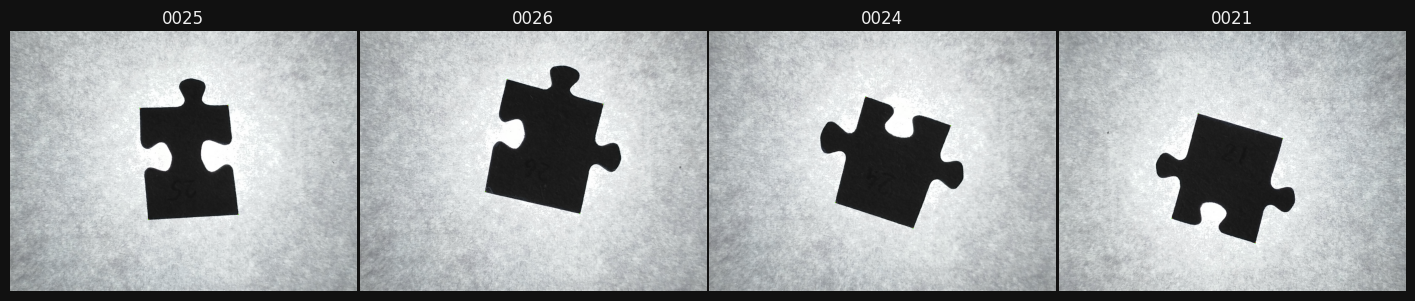

In [21]:
for piece in tqdm(SAMPLE):
    piece["corners_refined"] = refine_corners(
        piece["binary"], piece["corners_selected"]
    )

    piece["preview"] = piece["img"].copy()

    for point in piece["corners_selected"]:
        point = np.int32(point)
        piece["preview"] = cv2.circle(
            piece["preview"], point, 5, color=RED, thickness=-1
        )

    for point in piece["corners_refined"]:
        point = np.int32(point)
        piece["preview"] = cv2.circle(
            piece["preview"], point, 5, color=GREEN, thickness=-1
        )

print("Piece dict:")
preview_contents(SAMPLE)

show_imgs(SAMPLE, "preview")

# Full dataset

In [23]:
imgs_directory = os.path.join("data", "imgs")

out_path = os.path.join("data", "01_images_out")
preview_path = os.path.join(out_path, "preview")

if os.path.exists(out_path):
    shutil.rmtree(out_path)
os.makedirs(out_path)
os.makedirs(preview_path)


DATA = []
for file_name in tqdm(os.listdir(imgs_directory)):
    piece_name = get_piece_name(file_name)

    img = load_img(os.path.join(imgs_directory, file_name))
    img_binary = to_binary(to_blurred(to_grayscale(img)))
    img_edge = to_edges(img_binary)
    edge_pixels = get_edge_pixels(img_edge)
    corners_potential = get_corners(to_harris(img_edge))
    corners_selected = select_corners(corners_potential)
    corners = refine_corners(img_binary, corners_selected)

    DATA.append({"name": piece_name, "edge_pixels": edge_pixels, "corners": corners})

    # Export preview
    for point in edge_pixels:
        img = cv2.circle(img, np.int32(point), 3, color=RED, thickness=-1)

    for point in corners:
        img = cv2.circle(img, np.int32(point), 5, color=GREEN, thickness=-1)

    cv2.imwrite(os.path.join(preview_path, file_name), img)

preview_contents(DATA)

with open(os.path.join(out_path, "out.pickle"), "wb") as f:
    pickle.dump(DATA, f)

100%|██████████| 40/40 [00:35<00:00,  1.12it/s]

[{'corners': <class 'numpy.ndarray'>,
  'edge_pixels': <class 'numpy.ndarray'>,
  'name': <class 'str'>}]
